# DataJoint U24 - Workflow Miniscope


## Setup


First, let's change directories to find the `dj_local_conf` file.


In [1]:
import os

# change to the upper level folder to detect dj_local_conf.json
if os.path.basename(os.getcwd()) == "notebooks":
    os.chdir("..")
assert (
    os.path.basename(os.getcwd()) == "workflow-miniscope"
), "Please move to the workflow directory"
# We'll be working with long tables, so we'll make visualization easier with a limit
import datajoint as dj

dj.config["display.limit"] = 10

Next, we populate the python namespace with the required schemas


In [2]:
from workflow_miniscope.pipeline import miniscope, trial, event

Connecting cbroz@dss-db.datajoint.io:3306


## Trial and Event schemas


Tables in the `trial` and `event` schemas specify the structure of your experiment, including block, trial and event timing.

- Session has a 1-to-1 mapping with a behavior recording
- A block is a continuous phase of an experiment that contains repeated instances of a condition, or trials.
- Events may occur within or outside of conditions, either instantaneous or continuous.

The diagram below shows (a) the levels of hierarchy and (b) how the bounds may not completely overlap. A block may not fully capture trials and events may occur outside both blocks/trials.


```
|----------------------------------------------------------------------------|
|-------------------------------- Session ---------------------------------|__
|-------------------------- BehaviorRecording ---------------------------|____
|----- Block 1 -----|______|----- Block 2 -----|______|----- Block 3 -----|___
| trial 1 || trial 2 |____| trial 3 || trial 4 |____| trial 5 |____| trial 6 |
|_|e1|_|e2||e3|_|e4|__|e5|__|e6||e7||e8||e9||e10||e11|____|e12||e13|_________|
|----------------------------------------------------------------------------|
```


Let's load some example data. The `ingest.py` script has a series of loaders to help. If you've already run the other notebooks, you might skip `ingest_subjects` and `ingest_sessions`.


In [3]:
from workflow_miniscope.ingest import (
    ingest_subjects,
    ingest_sessions,
    ingest_events,
    ingest_alignment,
)

If you've already run previous notebooks, no need to ingest subjects or sessions.


In [4]:
ingest_subjects()
ingest_sessions()
ingest_events()


---- Inserting 0 entry(s) into behavior_recording ----

---- Inserting 0 entry(s) into behavior_recording__file ----

---- Inserting 2 entry(s) into _block ----

---- Inserting 2 entry(s) into _block__attribute ----

---- Inserting 0 entry(s) into #trial_type ----

---- Inserting 50 entry(s) into _trial ----

---- Inserting 50 entry(s) into _trial__attribute ----

---- Inserting 50 entry(s) into _block_trial ----

---- Inserting 0 entry(s) into #event_type ----

---- Inserting 77 entry(s) into _event ----

---- Inserting 77 entry(s) into _trial_event ----


We have 50 total trials, either 'stim' or 'ctrl', with start and stop time


In [6]:
trial.Trial() & "subject='subject1'"

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject1,2021-01-01 00:00:01,1,stim,0.193,1.057
subject1,2021-01-01 00:00:01,2,ctrl,1.468,2.332
subject1,2021-01-01 00:00:01,3,ctrl,2.662,3.526
subject1,2021-01-01 00:00:01,4,ctrl,3.738,4.602
subject1,2021-01-01 00:00:01,5,stim,4.826,5.69
subject1,2021-01-01 00:00:01,6,stim,5.973,6.837
subject1,2021-01-01 00:00:01,7,ctrl,7.252,8.116
subject1,2021-01-01 00:00:01,8,ctrl,8.462,9.326
subject1,2021-01-01 00:00:01,9,ctrl,9.731,10.595
subject1,2021-01-01 00:00:01,10,stim,11.019,11.883


Each trial is paired with one or more events that take place during the trial window.


In [7]:
trial.TrialEvent() & "trial_id<5" & "subject='subject1'"

subject,session_datetime,trial_id trial number (1-based indexing),event_type,event_start_time (second) relative to recording start
subject1,2021-01-01 00:00:01,1,left,0.407
subject1,2021-01-01 00:00:01,1,right,0.269
subject1,2021-01-01 00:00:01,2,center,1.611
subject1,2021-01-01 00:00:01,2,center,1.649
subject1,2021-01-01 00:00:01,3,left,2.777
subject1,2021-01-01 00:00:01,3,left,2.935
subject1,2021-01-01 00:00:01,4,right,4.006


Finally, the `AlignmentEvent` describes the event of interest and the window we'd like to see around it.


In [7]:
ingest_alignment()


---- Inserting 3 entry(s) into alignment_event ----


In [8]:
event.AlignmentEvent()

alignment_name,alignment_description,alignment_event_type,alignment_time_shift (s) WRT alignment_event_type,start_event_type,start_time_shift (s) WRT start_event_type,end_event_type,end_time_shift (s) WRT end_event_type
center_button,,center,0.0,center,-5.0,center,5.0
left_button,,left,0.0,left,-5.0,left,5.0
right_button,,right,0.0,right,-5.0,right,5.0


# Event-aligned trialized calcium activity


In [3]:
from workflow_miniscope import analysis

### Analysis


The `analysis` schema provides example tables to perform event-aligned Calcium activity analysis.

- **_ActivityAlignmentCondition_** - a manual table to specify the inputs and condition for the analysis
- **_ActivityAlignment_** - a computed table to extract event-aligned Calcium activity (e.g. dF/F, spikes)


Let's start by creating several analyses configuration - i.e. inserting into **_ActivityAlignmentCondition_**


In [4]:
miniscope.Activity()

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method
subject1,2021-01-01 00:00:01,0,0,0,caiman_deconvolution
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff


We'll isolate the scan of interest with the following key:


In [18]:
activity_key = (
    miniscope.Activity & {"subject": "subject1", "extraction_method": "caiman_dff"}
).fetch1("KEY")

Here, we can see all trials for this scan:


In [19]:
trial.Trial & activity_key

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject1,2021-01-01 00:00:01,1,stim,0.193,1.057
subject1,2021-01-01 00:00:01,2,ctrl,1.468,2.332
subject1,2021-01-01 00:00:01,3,ctrl,2.662,3.526
subject1,2021-01-01 00:00:01,4,ctrl,3.738,4.602
subject1,2021-01-01 00:00:01,5,stim,4.826,5.69
subject1,2021-01-01 00:00:01,6,stim,5.973,6.837
subject1,2021-01-01 00:00:01,7,ctrl,7.252,8.116
subject1,2021-01-01 00:00:01,8,ctrl,8.462,9.326
subject1,2021-01-01 00:00:01,9,ctrl,9.731,10.595
subject1,2021-01-01 00:00:01,10,stim,11.019,11.883


And highlight a subset based on `trial_type`


In [20]:
ctrl_trials = trial.Trial & activity_key & 'trial_type = "ctrl"'
ctrl_trials

subject,session_datetime,trial_id trial number (1-based indexing),trial_type,trial_start_time (second) relative to recording start,trial_stop_time (second) relative to recording start
subject1,2021-01-01 00:00:01,2,ctrl,1.468,2.332
subject1,2021-01-01 00:00:01,3,ctrl,2.662,3.526
subject1,2021-01-01 00:00:01,4,ctrl,3.738,4.602
subject1,2021-01-01 00:00:01,7,ctrl,7.252,8.116
subject1,2021-01-01 00:00:01,8,ctrl,8.462,9.326
subject1,2021-01-01 00:00:01,9,ctrl,9.731,10.595
subject1,2021-01-01 00:00:01,13,ctrl,14.427,15.291
subject1,2021-01-01 00:00:01,14,ctrl,15.563,16.427
subject1,2021-01-01 00:00:01,15,ctrl,16.715,17.579
subject1,2021-01-01 00:00:01,16,ctrl,17.706,18.57


Here, we target the event of interest with another key:


In [21]:
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"').fetch1(
    "KEY"
)
alignment_key

{'alignment_name': 'center_button'}

In [23]:
alignment_condition = {
    **activity_key,
    **alignment_key,
    "trial_condition": "ctrl_center_button",
}
alignment_condition

{'subject': 'subject1',
 'session_datetime': datetime.datetime(2021, 1, 1, 0, 0, 1),
 'recording_id': 0,
 'paramset_id': 0,
 'curation_id': 0,
 'extraction_method': 'caiman_dff',
 'alignment_name': 'center_button',
 'trial_condition': 'ctrl_center_button'}

Next, we add this to the `ActivityAlignment` table in the `analysis` schema


In [24]:
analysis.ActivityAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)

In [25]:
analysis.ActivityAlignmentCondition()

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,condition_description,bin_size bin-size (in second) used to compute the PSTH
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,,0.04


Using the [projection](https://docs.datajoint.org/python/v0.13/queries/08-Proj.html) method, we can generate a table of relevant trials by `trial_type` and `alignment_condition`


In [26]:
sample = (
    analysis.ActivityAlignmentCondition * ctrl_trials & alignment_condition
).proj()
sample

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,2
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,3
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,4
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,7
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,8
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,9
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,13
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,14
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,15
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,16


And insert these trials into the `ActivityAlignmentCondition.Trial` part table


In [27]:
analysis.ActivityAlignmentCondition.Trial.insert(sample, skip_duplicates=True)
analysis.ActivityAlignmentCondition.Trial()

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,2
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,3
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,4
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,7
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,8
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,9
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,13
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,14
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,15
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,16


With the steps above, we have create a new alignment condition for analysis, named `ctrl_center_button`, which specifies:

- an Activity of interest for analysis
- an event of interest to align the Ca+ activity to - `center_button`
- a set of trials of interest to perform the analysis on - `ctrl` trials

---


Now, let's create another set with:

- the same Activity of interest for analysis
- an event of interest to align the Ca+ activity to - `center_button`
- a set of trials of interest to perform the analysis on - `stim` trials


In [28]:
stim_trials = trial.Trial & activity_key & 'trial_type = "stim"'
alignment_condition = {
    **activity_key,
    **alignment_key,
    "trial_condition": "stim_center_button",
}
analysis.ActivityAlignmentCondition.insert1(alignment_condition, skip_duplicates=True)
analysis.ActivityAlignmentCondition.Trial.insert(
    (analysis.ActivityAlignmentCondition * stim_trials & alignment_condition).proj(),
    skip_duplicates=True,
)

Note the two entries in `ActivityAlignmentCondition.trial_condition`


In [29]:
analysis.ActivityAlignmentCondition()

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,condition_description,bin_size bin-size (in second) used to compute the PSTH
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,,0.04
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,stim_center_button,,0.04


In [30]:
analysis.ActivityAlignmentCondition.Trial & 'trial_condition = "ctrl_center_button"'

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,trial_id trial number (1-based indexing)
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,2
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,3
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,4
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,7
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,8
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,9
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,13
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,14
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,15
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,16


### Computation

Just like the element itself, we can run computations with `populate()`


In [4]:
analysis.ActivityAlignment.populate(display_progress=True)

ActivityAlignment: 100%|█████████████████████████████████████████████████████████| 2/2 [00:10<00:00,  5.34s/it]


In [5]:
analysis.ActivityAlignment()

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,aligned_timestamps
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,stim_center_button,=BLOB=


The `AlignedTrialActivity` part table captures aligned traces fore each alignment and trial condition specified in the master table.


In [7]:
analysis.ActivityAlignment.AlignedTrialActivity()

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method,alignment_name,trial_condition user-friendly name of condition,mask_id,fluorescence_channel 0-based indexing,trial_id trial number (1-based indexing),aligned_trace (s) Calcium activity aligned to the event time
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,2,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,7,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,8,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,9,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,20,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,27,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,37,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,43,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,46,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff,center_button,ctrl_center_button,1,0,50,=BLOB=


### Visualization


With the `plot_aligned_activities` function, we can see the density of activity relative to our alignment event. For more information, see the corresponding docstring.


In [8]:
help(analysis.ActivityAlignment().plot_aligned_activities)

Help on method plot_aligned_activities in module workflow_miniscope.analysis:

plot_aligned_activities(key, roi, axs=None, title=None) method of workflow_miniscope.analysis.ActivityAlignment instance
    Plot event-aligned Calcium activities for all selected trials, and
        trial-averaged Calcium activity
        e.g. dF/F, neuropil-corrected dF/F, Calcium events, etc.
    :param key: key of ActivityAlignment master table
    :param roi: miniscope segmentation mask
    :param axs: optional definition of axes for plot.
                Default is plt.subplots(2, 1, figsize=(12, 8))
    :param title: Optional title label



For a refresher on the differences between masks, we can browse the `imaging.Segmentation.Mask` table.


In [10]:
miniscope.Segmentation.Mask & "mask_id<3"

subject,session_datetime,recording_id,paramset_id,curation_id,mask_id,segmentation_channel 0-based indexing,mask_npix number of pixels in this mask,mask_center_x (pixels) center x coordinate,mask_center_y (pixels) center y coordinate,mask_xpix (pixels) x coordinates,mask_ypix (pixels) y coordinates,mask_weights weights of the mask at the indices above
subject1,2021-01-01 00:00:01,0,0,0,1,0,209,87,8,=BLOB=,=BLOB=,=BLOB=
subject1,2021-01-01 00:00:01,0,0,0,2,0,896,83,240,=BLOB=,=BLOB=,=BLOB=


Then, we can directly compare the stimulus and control conditions relative to center button presses.


In [6]:
miniscope.Activity()

subject,session_datetime,recording_id,paramset_id,curation_id,extraction_method
subject1,2021-01-01 00:00:01,0,0,0,caiman_deconvolution
subject1,2021-01-01 00:00:01,0,0,0,caiman_dff


In [7]:
from workflow_miniscope import analysis
from workflow_miniscope.pipeline import miniscope, trial, event

activity_key = (
    miniscope.Activity
    & {"subject": "subject1", "recording_id": 0}
    & "extraction_method='caiman_dff'"
).fetch1("KEY")
alignment_key = (event.AlignmentEvent & 'alignment_name = "center_button"').fetch1(
    "KEY"
)
alignment_condition_ctrl = {
    **activity_key,
    **alignment_key,
    "trial_condition": "ctrl_center_button",
}
alignment_condition_stim = {
    **activity_key,
    **alignment_key,
    "trial_condition": "stim_center_button",
}

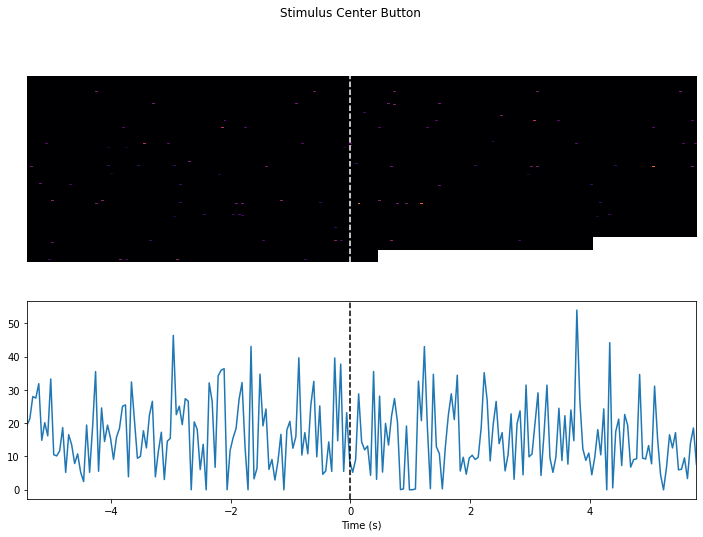

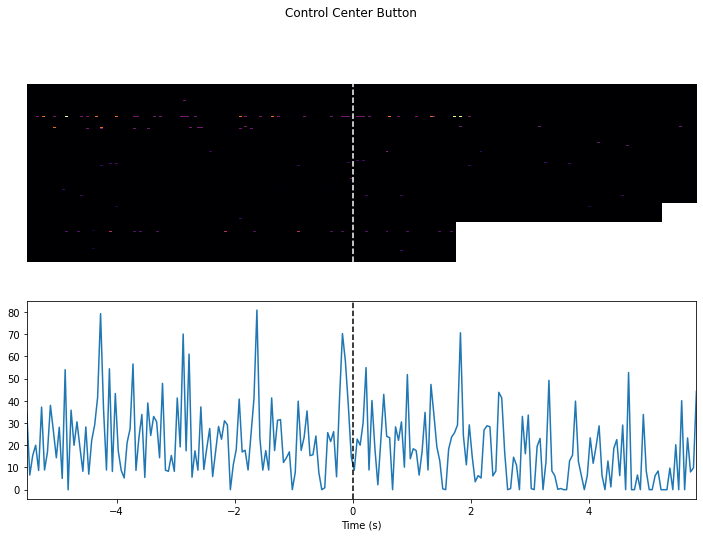

In [8]:
analysis.ActivityAlignment().plot_aligned_activities(
    alignment_condition_stim, roi=2, title="Stimulus Center Button"
)
analysis.ActivityAlignment().plot_aligned_activities(
    alignment_condition_ctrl, roi=2, title="Control Center Button"
)